In [1]:
import numpy as np
import sys
import itertools
from data import *
from models import *
from utils import *
from detect import detect_Hessian_UCB,detectNID
from sklearn.model_selection import KFold
import os, shutil, pickle
from sklearn.metrics import roc_auc_score

In [2]:
from itertools import combinations
p = 10
def generate_comMat(p,h):
    combolist = list(combinations(range(p),2)) 
    comMat=np.zeros([4*int(p*(p-1)/2), p])
    for i in range(len(combolist)):
        comMat[i*4,combolist[i][0]] = 1
        comMat[i*4,combolist[i][1]] = 1
        comMat[i*4+1,combolist[i][0]] = 1
        comMat[i*4+1,combolist[i][1]] = -1
        comMat[i*4+2,combolist[i][0]] = -1
        comMat[i*4+2,combolist[i][1]] = 1
        comMat[i*4+3,combolist[i][0]] = -1
        comMat[i*4+3,combolist[i][1]] = -1
    return comMat*h


In [3]:
ctx=mx.gpu(0)
aucs=[]

ground_truth_dict={}
ground_truth_dict['0']=[(0,1),(1,2),(0,2),(2,4),(6,7),(6,8),(6,9),(7,8),(7,9),(8,9),(1,6)]
ground_truth_dict['1']=[(0,1),(1,2),(0,2),(2,4),(6,7),(6,8),(6,9),(7,8),(7,9),(8,9),(1,6)]
ground_truth_dict['2']=[(0,1),(1,2),(2,3),(3,4),(3,6),(4,6),(3,7),(4,7),(6,7)]
ground_truth_dict['3']=[(0,1),(1,2),(2,3),(3,4),(3,6),(4,6),(3,7),(4,7),(6,7),(0,3)]
ground_truth_dict['4']=[(0,1),(0,2),(1,2),(3,4),(5,6),(7,8),(7,9),(8,9)]
ground_truth_dict['5']=[(0,1),(2,3),(4,5),(4,7),(5,7),(7,8),(7,9),(8,9)]
ground_truth_dict['6']=[(0,1),(2,3),(3,4),(2,5),(3,5),(4,5),(3,6),(4,6),(5,6),(3,7),(4,7),(5,7),(6,7),(6,8)]
ground_truth_dict['7']=[(0,1),(2,3),(2,4),(3,4),(2,5),(4,5),(2,6),(3,6),(4,6),(7,8)]
ground_truth_dict['8']=[(0,1),(0,2),(1,2),(0,3),(1,3),(2,3),(0,4),(1,4),(2,4),(3,4),(4,5),(5,6),(5,7),(6,7),(8,9)]
ground_truth_dict['9']=[(0,1),(2,4),(3,4),(2,6),(4,6),(6,8)]

Larms=[]
for i in itertools.combinations(range(10),2):
    Larms.append(i)
    
for datasetindex in range(10):
    dataset=str(datasetindex)+'.csv'
    X, y= get_data(dataset)    

    ground_vec=np.zeros(45)
    for i in range(45):
        if Larms[i] in ground_truth_dict[str(datasetindex)]:
            ground_vec[i]=1 

    X_train=nd.array(X).as_in_context(ctx)
    y_train=nd.array(y).as_in_context(ctx)
    train_dataset = ArrayDataset(X_train, y_train)
#        num_workers=4
    train_data = DataLoader(train_dataset, batch_size=10, shuffle=True)
    FCnet=build_FC(train_data,ctx)

    for seed in range(5):

        FCnet.load_parameters('Selected_models/FCnet_'+str(datasetindex)+'_seed_'+str(seed),ctx=ctx)
        for pulls in [1,2,4,8,32,64,128,256]:

            for delta in np.arange(0.05,1.55,0.05):
                comMat = generate_comMat(p,delta)
                Hessian_vec = np.zeros(int(p*(p-1)/2))
                ## cal interaction strength for one sample.
                for i in range(pulls):
                    X_dup = np.tile(X_train.asnumpy()[i,:], (4*int(p*(p-1)/2), 1))+comMat
                    cc=FCnet(nd.array(X_dup).as_in_context(ctx)).reshape(int(p*(p-1)/2),4).asnumpy()
                    inter_temp = ((cc[:,0]-cc[:,1]-cc[:,2]+cc[:,3])**2)
                    Hessian_vec = Hessian_vec + inter_temp
                    if i%10 ==0:
                        print("evaluated on ",i, " points")
                # normalize
                Hessian_vec = Hessian_vec/max(Hessian_vec)

                aucs.append(roc_auc_score(ground_vec,Hessian_vec))

        
        

(12500, 10)
(12500, 1)
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  

evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evalu

evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  p

evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  poin

evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluate

evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0 

evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evalu

evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  p

evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  poin

evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
ev

evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
e

evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  point

evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  

evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evalua

evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
e

evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated 

evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  p

evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  

evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
e

evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
eva

evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated 

evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  p

evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
eva

evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evalua

evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
e

evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluat

evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  

evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points

evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluate

evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points


evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evalu

evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  p

evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
eval

evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
e

evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  po

evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evalua

evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  p

evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
eva

evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evalu

evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0 

evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evalua

evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  p

evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evalua

evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
ev

evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0 

evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evalua

evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  

evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluate

evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
e

evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  po

evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  poin

evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  p

evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  point

evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluate

evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated 

evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  po

evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluate

evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluate

evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points

evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated 

evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  p

evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluate

evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points


evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
e

evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evalua

evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  p

evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
e

evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points


evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluate

evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evalua

evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  p

evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  poin

evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
ev

evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
(12500, 10)
(12500, 1)
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  

evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evalu

evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  

evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evalu

evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points

evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0 

evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evalu

evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  

evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
e

evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
eva

evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0 

evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evalua

evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  

evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evalua

evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  poin

evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on

evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  p

evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  p

evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
ev

evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
ev

evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated 

evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  

evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluate

evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points

evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluate

evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated

evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  p

evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
e

evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluat

evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points


evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evalua

evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  

evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points


evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluate

evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  poin

evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evalu

evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  p

evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evalu

evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points


evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
eval

evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evalua

evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  

evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  poin

evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluate

evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0 

evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evalua

evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  p

evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  poin

evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evalua

evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on 

evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evalu

evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  p

evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluate

evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  poin

evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0 

evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  po

evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  p

evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  poin

evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluate

evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated 

evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  po

evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated o

evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evalu

evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  poin

evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated 

evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  p

evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evalua

evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  poin

evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluat

evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evalua

evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  p

evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  point

evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evalua

evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points

evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evalua

evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  p

evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evalua

evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  poin

evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evalua

evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evalua

evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  p

evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluate

evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  poin

evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0 

evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evalua

evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  p

evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluate

evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
eva

evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
ev

evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
ev

evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  p

evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluate

evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  poin

evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated 

evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  

evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  p

evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  point

evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluate

evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated 

evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  p

evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
eva

evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  poin

evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluat

evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluate

evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  

evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points


evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
e

evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  point

evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evalu

evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  p

evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points

evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluate

evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  point

evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evalua

evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  p

evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
e

evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evalu

evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evalu

evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evalua

evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  p

evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
eval

evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
e

evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0 

evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evalua

evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  p

evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evalua

evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points

evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0 

evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evalua

evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  

evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  poin

evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evalu

evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
e

evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points

evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  

evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points


evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
e

evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated 

evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  p

evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  p

evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  point

evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
eva

evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated 

evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  po

evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points


evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evalua

evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
eva

evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluate

evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  p

evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points


evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluate

evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evalu

evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evalu

evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  p

evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
ev

evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  poin

evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
eva

evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evalua

evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  p

evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
e

evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
eval

evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0 

evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evalua

evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  

evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
eva

evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluate

evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0  points
evaluated on  0 

evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evalu

evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  p

evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
ev

evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluated on  110  points
evaluated on  120  points
evaluated on  130  points
evaluated on  140  points
evaluated on  150  points
evaluated on  160  points
evaluated on  170  points
evaluated on  180  points
evaluated on  190  points
evaluated on  200  points
evaluated on  210  points
evaluated on  220  points
evaluated on  230  points
evaluated on  240  points
evaluated on  250  points
evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points
evaluated on  100  points
evaluate

In [4]:
auctensor=(np.array(aucs).reshape(10,5,8,30))

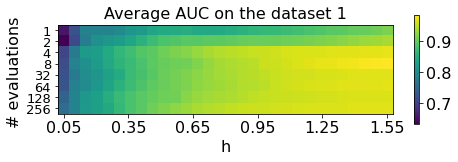

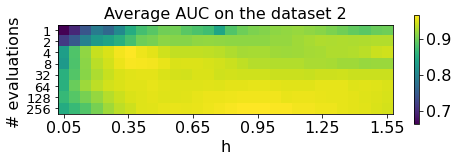

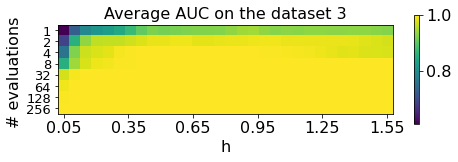

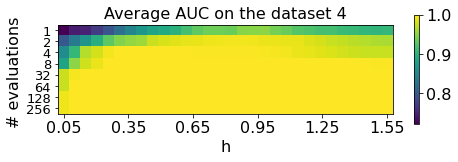

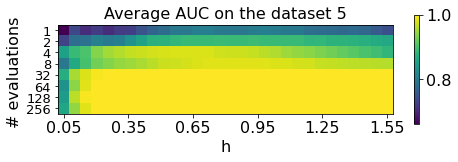

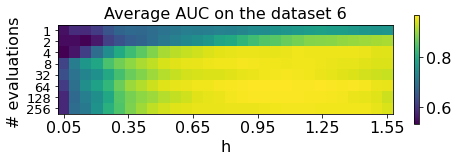

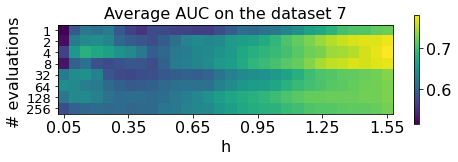

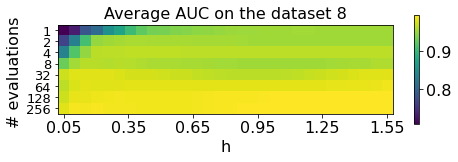

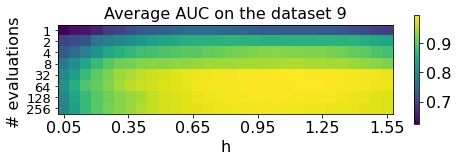

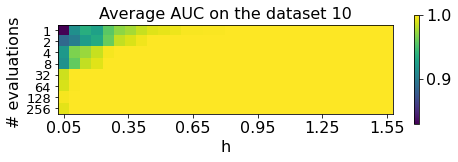

In [6]:
import matplotlib.pyplot as plt
for i in range(10):
    fig=plt.figure(figsize=(7.5, 2))
    h=plt.imshow(np.mean(auctensor[i,:,:,:],0))
    #cb=ax.colorbar(h)
    plt.title("Average AUC on the dataset "+str(i+1),fontsize=16)
    plt.xlabel("h",fontsize=16)
    plt.ylabel("# evaluations ",fontsize=16)
    ax=plt.gca()
    ax.set_xticks(np.linspace(0,29,6))
    ax.set_xticklabels(("0.05","0.35","0.65","0.95","1.25","1.55"))
    ax.set_yticks(np.linspace(0,7,8))
    ax.set_yticklabels([1,2,4,8,32,64,128,256])
    cbar = plt.colorbar(h)
    cbar.ax.tick_params(labelsize=16)  
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=13)
    #cbar.set_label('$T_B(K)$',fontdict=font)
    #cbar.set_ticks(np.linspace(160,300,8))
    #plt.show()
    plt.savefig('AUC_vs_h_evaluations/dataset'+str(i+1)+'.pdf',bbox_inches='tight',dpi=fig.dpi,pad_inches=0.1)
    #cb.set_ticks([0, 0.25,0.5, 0.75, 1])